In [ ]:
import os
import shutil
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from google.colab import files

# Define original and new class directories
leopard_dir = '/content/drive/MyDrive/Leopard'
markhor_dir = '/content/drive/MyDrive/Markhor'
bear_dir = '/content/drive/MyDrive/Bear'
orangutan_dir = '/content/drive/MyDrive/Orangutan'
kakapo_dir = '/content/drive/MyDrive/Kakapo'
chimpanzee_dir = '/content/drive/MyDrive/Chimpanzee'
panda_dir = '/content/drive/MyDrive/Panda'

# Define the new parent directory for organizing the dataset
parent_dir = '/content/drive/MyDrive/AnimalDataset'

# Create the parent directory if it doesn't exist
if not os.path.exists(parent_dir):
    os.makedirs(parent_dir)

# Define target subdirectories
classes = ['Leopard', 'Markhor', 'Bear', 'Orangutan', 'Kakapo', 'Chimpanzee', 'Panda']
for cls in classes:
    cls_dir = os.path.join(parent_dir, cls)
    if not os.path.exists(cls_dir):
        os.makedirs(cls_dir)

# Function to copy images to the new directory structure
def copy_images(src_dir, dest_dir):
    for filename in os.listdir(src_dir):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):  # Include common image extensions
            src_path = os.path.join(src_dir, filename)
            dest_path = os.path.join(dest_dir, filename)
            shutil.copy(src_path, dest_path)

# Copy images for each class
copy_images(leopard_dir, os.path.join(parent_dir, 'Leopard'))
copy_images(markhor_dir, os.path.join(parent_dir, 'Markhor'))
copy_images(bear_dir, os.path.join(parent_dir, 'Bear'))
copy_images(orangutan_dir, os.path.join(parent_dir, 'Orangutan'))
copy_images(kakapo_dir, os.path.join(parent_dir, 'Kakapo'))
copy_images(chimpanzee_dir, os.path.join(parent_dir, 'Chimpanzee'))
copy_images(panda_dir, os.path.join(parent_dir, 'Panda'))

print("All datasets organized successfully!")

# Define parameters for model training
IMAGE_SIZE = (224, 224)  # Use size compatible with MobileNetV2
BATCH_SIZE = 32
DATA_DIR = parent_dir  # New dataset location

# Create ImageDataGenerator with validation split
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,  # 20% of the data used for validation
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)

# Training data generator
train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation data generator
validation_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Print class indices for reference
print("Class indices:", train_generator.class_indices)

# Define the base model from MobileNetV2
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_tensor=Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))  # Define explicit input shape
)

# Freeze the base model's layers
base_model.trainable = False

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(len(classes), activation='softmax')(x)  # Output layer for classification

# Define the final model
model = Model(inputs=base_model.input, outputs=outputs)

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model structure
model.summary()

# Set number of epochs
EPOCHS = 10

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE
)

# Evaluate model on validation data
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Save the trained model
model_save_path = '/content/drive/MyDrive/AnimalClassifierModel_MobileNetV2.h5'
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

# Define class names for easy reference
class_names = list(train_generator.class_indices.keys())
print("Class names:", class_names)

# Function to classify an image
def classify_image(img_path, model, threshold=0.6):
    try:
        img = load_img(img_path, target_size=IMAGE_SIZE)
    except Exception as e:
        return f"Error loading image: {e}"

    img_array = img_to_array(img)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    predictions = model.predict(img_array)
    max_prob = np.max(predictions)
    predicted_class = np.argmax(predictions)

    if max_prob < threshold:
        return "safe"
    else:
        return class_names[predicted_class] + " - Endangered species detected"


All datasets organized successfully!
Found 1475 images belonging to 7 classes.
Found 365 images belonging to 7 classes.
Class indices: {'Bear': 0, 'Chimpanzee': 1, 'Kakapo': 2, 'Leopard': 3, 'Markhor': 4, 'Orangutan': 5, 'Panda': 6}


<ipython-input-4-c2a9e7160f5b>:94: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,422,855 (9.24 MB)

 Trainable params: 164,871 (644.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - accuracy: 0.7713 - loss: 0.7072 - val_accuracy: 0.9915 - val_loss: 0.0293
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 1.0000 - val_loss: 6.9229e-04
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.9813 - loss: 0.0599 - val_accuracy: 0.9886 - val_loss: 0.0238
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 1.0000 - loss: 0.0068 - val_accuracy: 1.0000 - val_loss: 3.7761e-04
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.9916 - loss: 0.0297 - val_accuracy: 0.9801 - val_loss: 0.0487
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 19s 367ms/step - accuracy: 0.9062 - loss: 0.2430 - val_accuracy: 1.0000 - val_loss: 2.0045e-04
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 122s 3s/step - accuracy: 0.9901 - loss: 0.0322 - val_accuracy: 0.9943 - val_loss: 0.0226
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 1.0000 - loss: 0.0031 - val_accura

Validation Loss: 0.034348264336586
Validation Accuracy: 0.9890410900115967
Model saved to /content/drive/MyDrive/AnimalClassifierModel_MobileNetV2.h5
Class names: ['Bear', 'Chimpanzee', 'Kakapo', 'Leopard', 'Markhor', 'Orangutan', 'Panda']


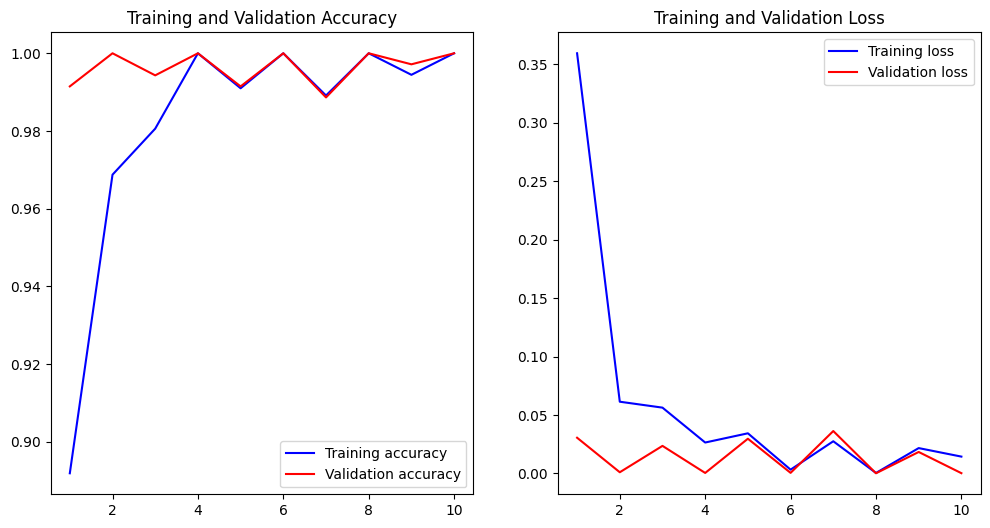

12/12 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step
Confusion Matrix:
 [[ 45   0   0   0   0   0   0]
 [  0 117   0   0   0   0   0]
 [  0   0  27   0   0   0   0]
 [  0   0   0  50   0   0   0]
 [  0   0   0   1  66   0   0]
 [  0   0   0   0   0  31   0]
 [  0   1   0   0   0   0  27]]


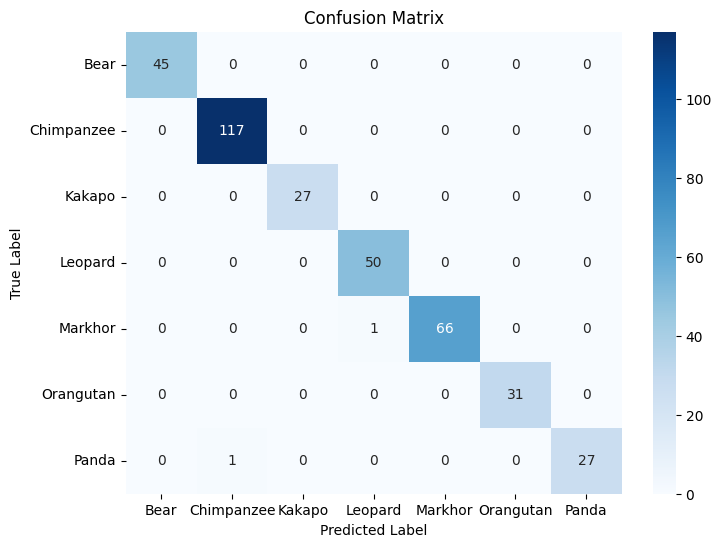

Classification Report:
               precision    recall  f1-score   support

        Bear       1.00      1.00      1.00        45
  Chimpanzee       0.99      1.00      1.00       117
      Kakapo       1.00      1.00      1.00        27
     Leopard       0.98      1.00      0.99        50
     Markhor       1.00      0.99      0.99        67
   Orangutan       1.00      1.00      1.00        31
       Panda       1.00      0.96      0.98        28

    accuracy                           0.99       365
   macro avg       1.00      0.99      0.99       365
weighted avg       0.99      0.99      0.99       365



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Plot training and validation accuracy/loss
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Accuracy plot
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

plot_history(history)

# Evaluate the model and compute predictions
val_generator = validation_generator
val_generator.reset()  # Ensure generator starts from the beginning
Y_pred = model.predict(val_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = val_generator.classes

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print classification report
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_names))


In [ ]:
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")


12/12 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.9966 - loss: 0.0129
Validation Accuracy: 98.90%


Saving sample_lepoard1.jpg to sample_lepoard1.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
Analyzing sample_lepoard1.jpg...


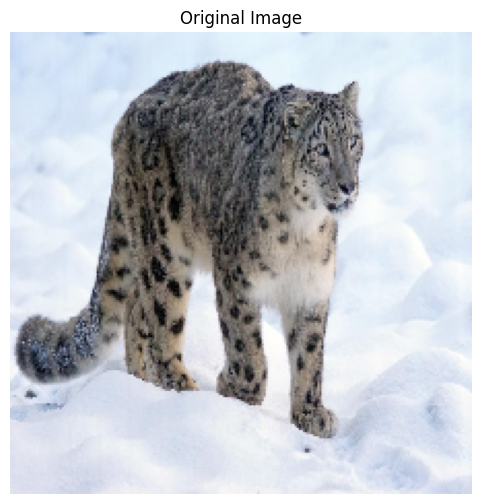

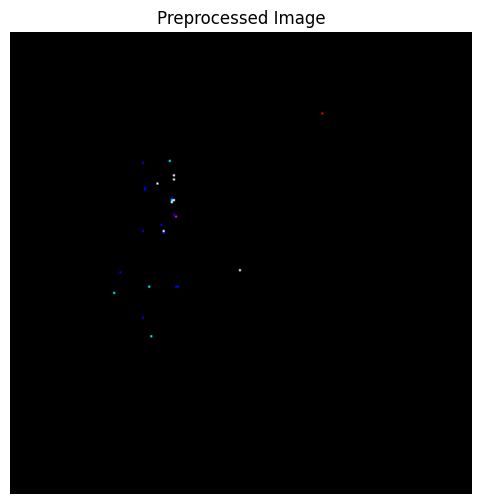

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


<ipython-input-10-82ae3683e82d>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_names, y=predictions[0], palette="viridis")


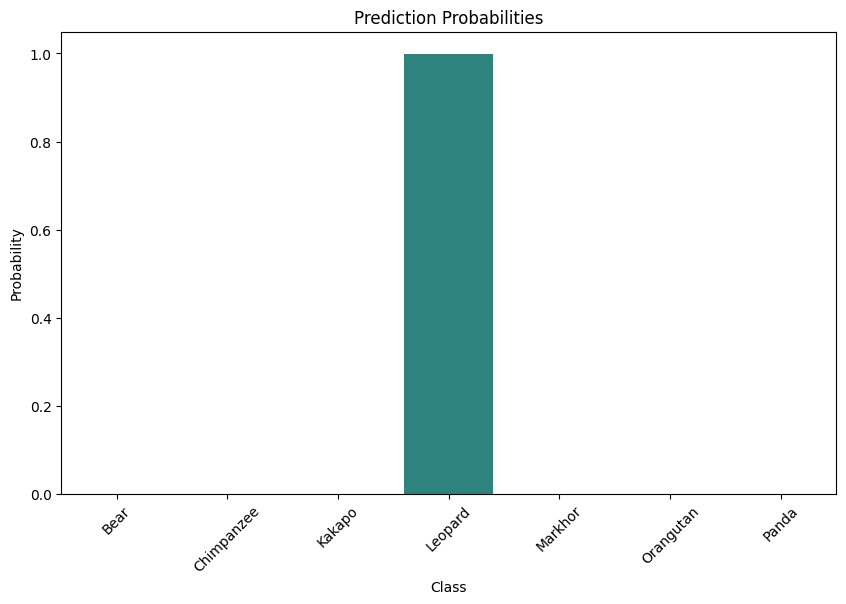

Leopard - Endangered species detected with 1.00 confidence


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications.mobilenet_v2 import decode_predictions

# Updated function to classify image with detailed visualization
def classify_and_visualize_image(img_path, model, threshold=0.6):
    try:
        # Step 1: Load and display the original image
        img = load_img(img_path, target_size=IMAGE_SIZE)
        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.axis('off')
        plt.title("Original Image")
        plt.show()

        # Step 2: Preprocess the image
        img_array = img_to_array(img)
        img_array = preprocess_input(img_array)
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Display the preprocessed image
        plt.figure(figsize=(6, 6))
        plt.imshow(img_array[0].astype('uint8'))  # Convert back to uint8 for visualization
        plt.axis('off')
        plt.title("Preprocessed Image")
        plt.show()

        # Step 3: Generate predictions
        predictions = model.predict(img_array)

        # Display the probability distribution
        plt.figure(figsize=(10, 6))
        sns.barplot(x=class_names, y=predictions[0], palette="viridis")
        plt.title("Prediction Probabilities")
        plt.ylabel("Probability")
        plt.xlabel("Class")
        plt.xticks(rotation=45)
        plt.show()

        # Step 4: Analyze predictions
        max_prob = np.max(predictions)
        predicted_class = np.argmax(predictions)

        # Step 5: Display the classification result
        if max_prob < threshold:
            result = "SAFE: No endangered species detected"
        else:
            result = f"{class_names[predicted_class]} - Endangered species detected with {max_prob:.2f} confidence"

        print(result)

        return result
    except Exception as e:
        print(f"Error processing image: {e}")
        return None

# Classify uploaded images with visualization
uploaded = files.upload()

for filename in uploaded.keys():
    img_path = os.path.join('/content', filename)
    with open(img_path, 'wb') as f:
        f.write(uploaded[filename])

    # Classify the uploaded image
    result = classify_image(img_path, model, threshold=0.6)

    img_path = os.path.join('/content', filename)
    with open(img_path, 'wb') as f:
        f.write(uploaded[filename])

    # Classify and visualize the uploaded image
    print(f"Analyzing {filename}...")
    classify_and_visualize_image(img_path, model, threshold=0.6)
